In [1]:
# some imports
import os
from skimage.draw import polygon
from scipy import interpolate
import numpy as np
np.random.seed(seed=1)
from glob import glob
from matplotlib import pyplot as plt
%matplotlib notebook
from natsort import natsorted
import keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

# import custom functions and viewing tools
from VisTools import multi_slice_viewer0, mask_viewer0
from KerasModel import BlockModel, dice_coef_loss

Using TensorFlow backend.


In [2]:
#~# some parameters to set for training #~#
# path to save best model weights
model_version = 1
model_weights_path = os.path.join(os.getcwd(),
                                  'BestModelWeights_v{:02d}.h5'.format(model_version))
# set number of subjects to be used for testing
test_num = 10
# set number of subjects to to be used for validation
val_num = 10
# whether to use data augmentation or not
augment = True
# how many iterations of data to train on
numEp = 30
# augmentation factor
augFact = 8

# set data directory
data_dir = os.path.join('/home','johnsonj118','output')
# find number of subjects
numSubjs = len(glob(os.path.join(data_dir, "input*.npy")))

In [3]:
# Randaomly select test subject indices
# numpy is seeded so this is repeatable
tv_inds = np.random.choice(numSubjs,test_num+val_num,replace=False)
test_inds = tv_inds[:test_num]
val_inds = tv_inds[test_num:]

In [4]:
input_files= natsorted(glob(os.path.join(data_dir, "input*.npy")))
print('{} input files found'.format(len(input_files)))
# split into test,train,validation
input_files_test = np.take(input_files,test_inds)
input_files_val = np.take(input_files,val_inds)
input_files_train = np.delete(input_files,tv_inds)

target_files= natsorted(glob(os.path.join(data_dir, "target*.npy")))
print('{} output files found'.format(len(target_files)))
# split into test and test/validation
target_files_test = np.take(target_files,test_inds)
target_files_val = np.take(target_files,val_inds)
target_files_train = np.delete(target_files,tv_inds)

44 input files found
44 output files found


In [5]:
# load input data
print('Loading input data...')
inputs_test = np.concatenate([np.load(f) for f in input_files_test])
inputs_val = np.concatenate([np.load(f) for f in input_files_val])
inputs_train = np.concatenate([np.load(f) for f in input_files_test])
# add singleton dimension for grayscale channel
testX = inputs_test[...,np.newaxis]
valX = inputs_val[...,np.newaxis]
trainX = inputs_train[...,np.newaxis]
print('Input data loaded')

Loading input data...
Input data loaded


In [6]:
# load input data
print('Loading target data...')
targets_test = np.concatenate([np.load(f) for f in target_files_test])
targets_val = np.concatenate([np.load(f) for f in target_files_val])
targets_train = np.concatenate([np.load(f) for f in target_files_test])
# add singleton dimension for grayscale channel
testY = targets_test[...,np.newaxis]
valY = targets_val[...,np.newaxis]
trainY = targets_train[...,np.newaxis]
print('Target data loaded')

Loading target data...
Target data loaded


In [7]:
# make model
model = BlockModel(trainX.shape,filt_num=16,numBlocks=4)
model.compile(optimizer=Adam(), loss=dice_coef_loss)

In [8]:
# setup image data generator
if augment:
    datagen1 = ImageDataGenerator(
        rotation_range=15,
        shear_range=0.5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
    datagen2 = ImageDataGenerator(
        rotation_range=15,
        shear_range=0.5,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest')
else:
    datagen1 = ImageDataGenerator()
    datagen2 = ImageDataGenerator()
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
datagen1.fit(trainX, seed=seed)
datagen2.fit(trainY, seed=seed)
batchsize = 16
datagen = zip( datagen1.flow( trainX, None, batchsize, seed=seed), datagen2.flow( trainY, None, batchsize, seed=seed) )

# calculate number of batches
if augment:
    steps = np.int(trainX.shape[0]/batchsize*augFact)
else:
    steps = np.int(trainX.shape[0]/batchsize)

In [9]:
# make callback for checkpointing
cb_check = ModelCheckpoint(model_weights_path,monitor='val_loss',
                                   verbose=0,save_best_only=True,
                                   save_weights_only=True,mode='auto',period=1)

In [10]:
# train model
history = model.fit_generator(datagen,
                    steps_per_epoch=steps,
                    epochs=numEp,
                    callbacks=[cb_check],
                    verbose=1,
                    validation_data=(valX,valY))

Epoch 1/30
150/150 [==============================] - 293s 2s/step - loss: 0.4714 - val_loss: 0.4114
Epoch 2/30
150/150 [==============================] - 274s 2s/step - loss: 0.2449 - val_loss: 0.8022
Epoch 3/30
150/150 [==============================] - 274s 2s/step - loss: 0.1994 - val_loss: 0.7463
Epoch 4/30
150/150 [==============================] - 274s 2s/step - loss: 0.1931 - val_loss: 0.7908
Epoch 5/30
150/150 [==============================] - 274s 2s/step - loss: 0.1731 - val_loss: 0.8003
Epoch 6/30
150/150 [==============================] - 274s 2s/step - loss: 0.1280 - val_loss: 0.2564
Epoch 7/30
150/150 [==============================] - 274s 2s/step - loss: 0.1551 - val_loss: 0.6418
Epoch 8/30
150/150 [==============================] - 274s 2s/step - loss: 0.1259 - val_loss: 0.3281
Epoch 9/30
150/150 [==============================] - 274s 2s/step - loss: 0.1099 - val_loss: 0.4364
Epoch 10/30
150/150 [==============================] - 274s 2s/step - loss: 0.1097 - val_lo

Test Dice score is 0.949


<IPython.core.display.Javascript object>


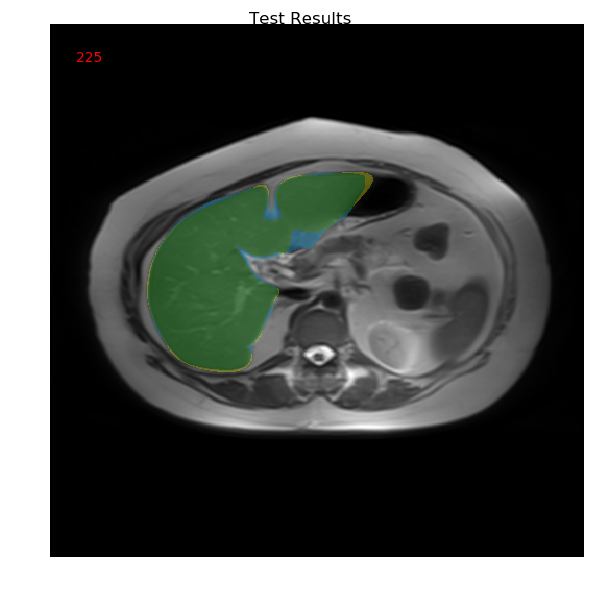

In [11]:
# load best weights
model.load_weights(model_weights_path)
# evaluate on test data
score = model.evaluate(testX,testY,verbose=0)
print("Test Dice score is {:.03f}".format(1-score))

# display some results
output = model.predict(testX,batch_size=16)
mask_viewer0(testX[...,0],testY[...,0],output[...,0],name='Test Results')
plt.show()

This set of cells can be run independently to get predicted volumes

In [6]:
import os
from KerasModel import CalcVolumes
from natsort import natsorted
from glob import glob
# set data directory
data_dir = os.path.join('/home','johnsonj118','output')
# set voxel dimensions (in cm)
sx = .7
sy = .1
sz = .2
vox_vol = sx*sy*sz
# select which model to load
model_version = 1
# get input/target files
input_files= natsorted(glob(os.path.join(data_dir, "input*.npy")))
target_files= natsorted(glob(os.path.join(data_dir, "input*.npy")))
# create model
from KerasModel import BlockModel
model = BlockModel((1,512,512,1),filt_num=16,numBlocks=4)
# load saved weights
model_weights_path = os.path.join(os.getcwd(),'BestModelWeights_v{:02d}.h5'.format(model_version))
model.load_weights(model_weights_path)

In [12]:
# choose subject to calculate volume of
subj_ind = 4
# run function to perform calculations
calc,truth = CalcVolumes(input_files[subj_ind],target_files[subj_ind],vox_vol,model)
# display result
print("The calculated volume is {:.02f} cm^3".format(calc))
print("The actual volume is {:.02f} cm^3".format(truth))

The calculated volume is 409.82 cm^3
The actual volume is 645.30 cm^3


In [18]:
# Get all volumes and plot correlation plot
import numpy as np
from matplotlib import pyplot as plt
%matplotlib notebook
results = [CalcVolumes(inp,targ,vox_vol,model) for inp,targ in zip(input_files,target_files)]

<IPython.core.display.Javascript object>


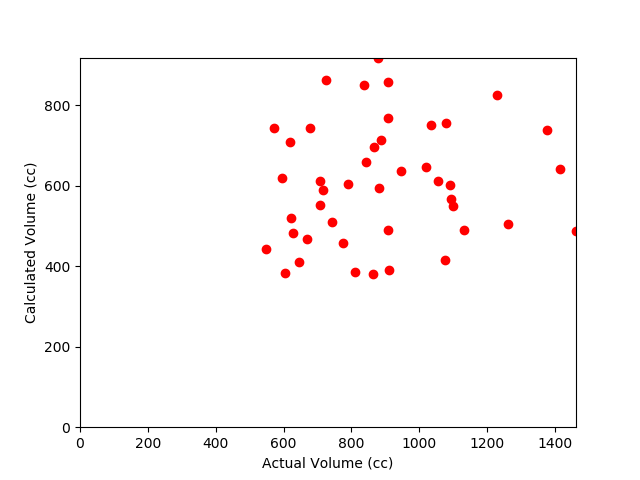

Correlation coefficient is 0.121


In [30]:
x = [r[1] for r in results]
y = [r[0] for r in results]
plt.plot(x,y,'ro')
plt.xlim([0,np.max(x)])
plt.ylim([0,np.max(y)])
plt.ylabel('Calculated Volume (cc)')
plt.xlabel('Actual Volume (cc)')
plt.show()
cc = np.corrcoef(x,y)[0,1]
print('Correlation coefficient is {:.03f}'.format(cc))